In [1]:
import torch
import torch.nn as nn

with open('input.txt', 'r') as f:
    data = f.read().splitlines()


chars = sorted(list(set(''.join(data))))
stoi = {ch: i + 1 for i, ch in enumerate(chars)}
stoi['.'] = 0
itos = {i: ch for ch, i in stoi.items()}



In [2]:
N = torch.zeros((27, 27), dtype=torch.float32)

for w in data:
    name = '.' + w + '.'
    for ch1, ch2 in zip(name, name[1:]):
        char1_idx = stoi[ch1]
        char2_idx = stoi[ch2]
        N[char1_idx, char2_idx] += 1



## Plotting out the embedding table
After createing the matrix N:
- Plot a 'heatmap' to show the probabilities 

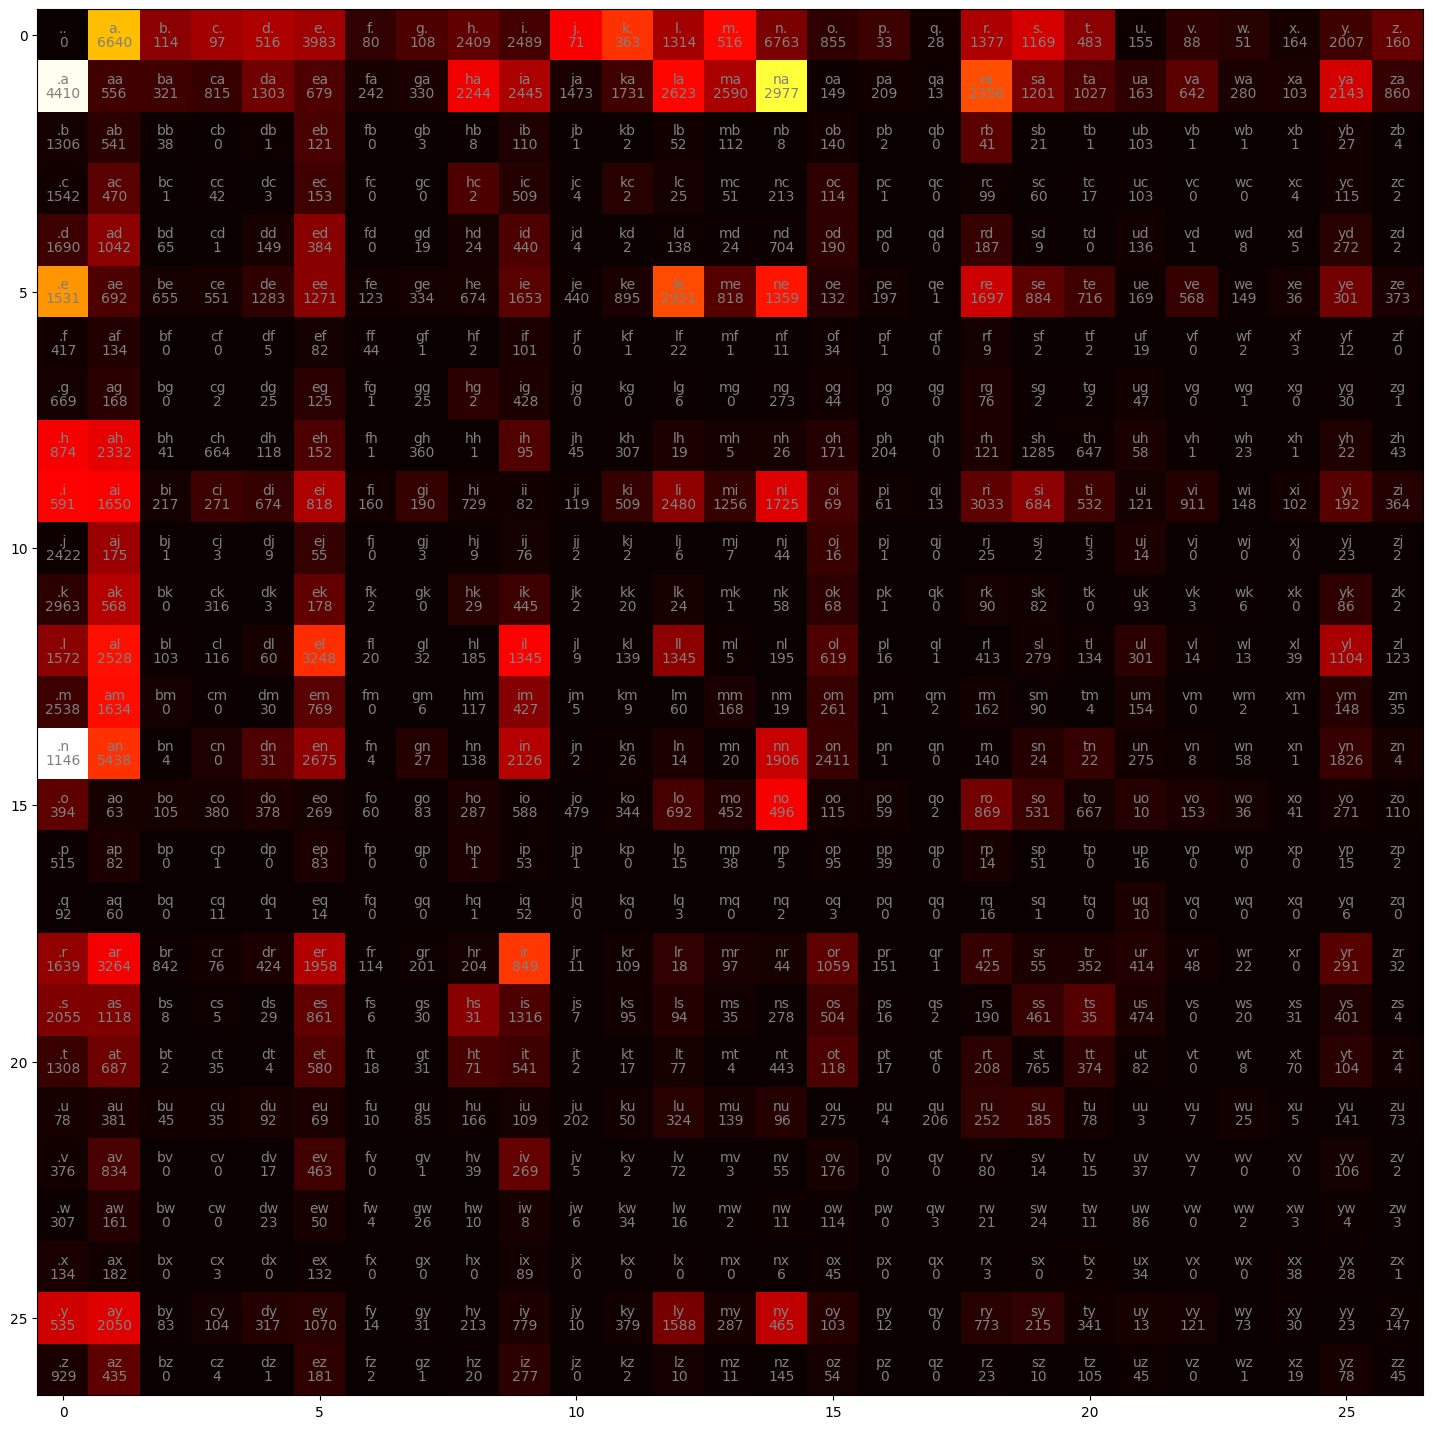

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 18))
plt.imshow(N, cmap='hot')
for i in range(27):
    for j in range(27):
        chstr = itos[i] + itos[j]
        plt.text(i, j, int(N[i, j]), ha='center', va='top', color='gray')
        plt.text(i, j, chstr, ha='center', va='bottom', color='gray')

In [4]:
P = N / N.sum(dim=1, keepdim=True)

# Splitting the data into training sets
- xs = inputs
- ys = expected output (next character of bigram)

In [5]:
xs , ys = [], []

for w in data[:1]:
    chs = ['.'] + list(w) + ['.']
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs, dtype=torch.float32)
ys = torch.tensor(ys, dtype=torch.float32)

xs, ys


(tensor([ 0.,  5., 13., 13.,  1.]), tensor([ 5., 13., 13.,  1.,  0.]))

## 1 Hot Encoding

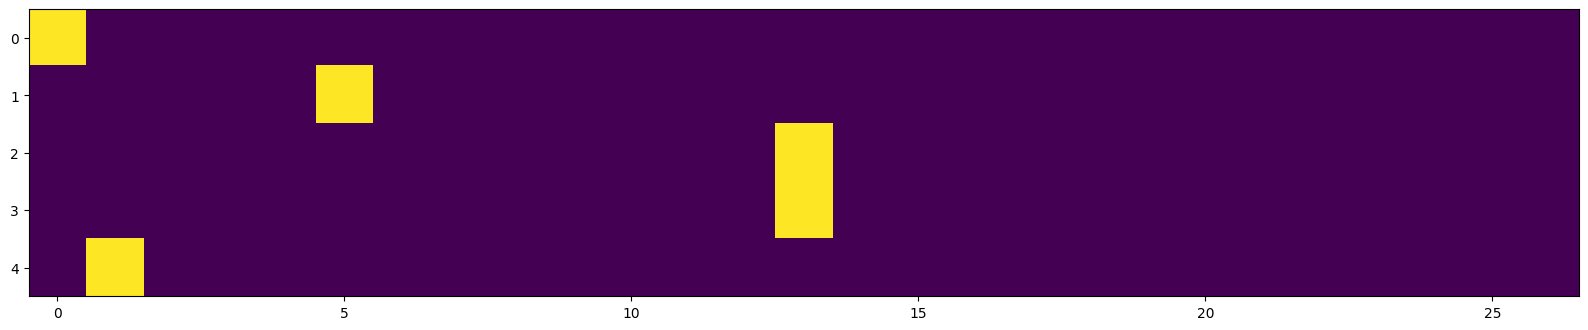

In [6]:
import torch.nn.functional as F

xenc = F.one_hot(xs.type(torch.int64), num_classes=27).float()
plt.figure(figsize=(20, 10))
plt.imshow(xenc)


In [7]:
xenc.shape, xenc.dtype, xenc

(torch.Size([5, 27]),
 torch.float32,
 tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.],
         [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
          0., 0., 0., 0., 0., 0., 0., 0., 0.]]))

## Neuron Simulation
- Input hot encoded matrix which is [5, 27]
- Input it into a weights matrix which is [27, 1]
- This will give a matrix of [27, 5]. This represents the one neurons random output for 5  different batches
- However, lets make it bigger.
- By turning the weights matrix into a larger 2dimensional matrice [27, 27]
    - We can capture more features of the data
    - Therefore, each batch now has 27 different neurons it can enter and therefore get 27 different outputs per batch

### Moving forward
How do we handle the semantics for each of the outputs?
- Right now we have some random positve and negative values
- We need these values to represent the probabilities for the next character like our table above
- So from this the number should be some positive number and be between 0 and 1
- We have our logits so what do we do?
- Exponents?

In [39]:
W1 = torch.randn((27 , 27), requires_grad=True)
logits = (xenc @ W1)
logits, logits[3, 13], (xenc[3] * W1[: ,13]).sum()

(tensor([[ 0.1247, -0.0518, -1.3386,  0.1766,  0.7243,  0.2767,  0.1647, -2.1874,
           1.1426, -0.4303, -0.8475,  0.9292, -1.8770,  1.1946,  0.5640,  0.8508,
          -1.1560, -0.2654, -0.5377,  0.4106, -0.1920,  0.3460,  0.7324,  0.0404,
          -0.9770,  0.5291,  3.4354],
         [ 0.9698,  0.6011,  1.0848,  0.2278,  0.1473, -1.6327,  0.0991,  0.6607,
          -0.9037, -0.6390, -1.4582, -0.3591,  1.7093,  0.1276, -0.5494, -0.0654,
          -0.6404, -1.3128, -0.5170, -0.3791,  0.5639,  0.9904,  1.8945, -0.3052,
           0.5484,  0.1159, -1.7794],
         [-0.9859,  0.6700, -0.0169, -1.9990, -0.9318,  0.5720,  0.5380,  0.3416,
          -0.4723,  0.7572,  0.2529,  0.0491,  1.1296,  0.2529,  0.7859, -2.4429,
          -0.8266,  2.1901,  1.0629,  0.5918, -0.5671, -0.7235,  2.0080,  1.2283,
           0.1708, -0.3780,  1.5915],
         [-0.9859,  0.6700, -0.0169, -1.9990, -0.9318,  0.5720,  0.5380,  0.3416,
          -0.4723,  0.7572,  0.2529,  0.0491,  1.1296,  0.2529,  0

### Using Exponents to turn our data into positive numbers  that are greater than 0
- This should hopefully give us something we can interperate as a probability
- We get our counts  then sum accross the rows to get our probabilities (Each row should sum to 1)
- This is essentially a softmax function (exponentiate then normalize them)


In [41]:
exponentiate = logits.exp()

probabilities = exponentiate / exponentiate.sum(dim=1, keepdim=True)

print("=========EXPONENTIATE=========")
print(exponentiate)
print("=========PROBABILITIES=========")
print(probabilities)


=========EXPONENTIATE=========
tensor([[ 1.1328,  0.9495,  0.2622,  1.1932,  2.0632,  1.3188,  1.1791,  0.1122,
          3.1348,  0.6503,  0.4285,  2.5326,  0.1531,  3.3023,  1.7577,  2.3415,
          0.3147,  0.7669,  0.5841,  1.5078,  0.8253,  1.4134,  2.0801,  1.0413,
          0.3764,  1.6975, 31.0433],
        [ 2.6373,  1.8241,  2.9588,  1.2558,  1.1587,  0.1954,  1.1041,  1.9362,
          0.4051,  0.5278,  0.2327,  0.6983,  5.5254,  1.1361,  0.5773,  0.9367,
          0.5271,  0.2691,  0.5963,  0.6845,  1.7576,  2.6924,  6.6494,  0.7370,
          1.7305,  1.1228,  0.1687],
        [ 0.3731,  1.9542,  0.9832,  0.1355,  0.3939,  1.7718,  1.7126,  1.4072,
          0.6236,  2.1323,  1.2877,  1.0503,  3.0944,  1.2877,  2.1944,  0.0869,
          0.4375,  8.9360,  2.8948,  1.8072,  0.5672,  0.4850,  7.4485,  3.4155,
          1.1863,  0.6852,  4.9109],
        [ 0.3731,  1.9542,  0.9832,  0.1355,  0.3939,  1.7718,  1.7126,  1.4072,
          0.6236,  2.1323,  1.2877,  1.0503,  3.

In [58]:
nlls = torch.zeros(5)
for i in range (5):
    x = xs[i].type(torch.int64).item()
    y = ys[i].type(torch.int64).item()
    p = probabilities[i, y]

    log_probabilities = torch.log(p)
    nll = -log_probabilities
    nlls[i] = nll

print("=========NLLS=========")
print(nlls)
print(nlls.mean().item())

=========NLLS=========
tensor([3.8847, 3.5624, 3.7224, 3.3052, 4.1583], grad_fn=<CopySlices>)
3.7266082763671875


## OPTIMIZATION TIME WOOOOOOOOOO

- Below is ys -> The expected outputs
- We can look at these outputs in probabilities -> probabilities[batch][lookup]

In [118]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
xenc = F.one_hot(xs.type(torch.int64), num_classes=27).float()
W = torch.randn((27, 27), requires_grad=True, dtype=torch.float32)
logits = xenc @ W
exponentiate = logits.exp()
probabilities = exponentiate / exponentiate.sum(dim=1, keepdim=True)

In [119]:
print(ys)
probabilities[0, 5], probabilities[1, 13], probabilities[2, 13], probabilities[3, 1],  probabilities[4, 0], 

tensor([ 5., 13., 13.,  1.,  0.])


(tensor(0.0585, grad_fn=<SelectBackward0>),
 tensor(0.0241, grad_fn=<SelectBackward0>),
 tensor(0.1202, grad_fn=<SelectBackward0>),
 tensor(0.0378, grad_fn=<SelectBackward0>),
 tensor(0.0339, grad_fn=<SelectBackward0>))

In [120]:
probabilities[torch.arange(5), ys.type(torch.int64)] # A way to look up the probabilities for the correct characters

tensor([0.0585, 0.0241, 0.1202, 0.0378, 0.0339], grad_fn=<IndexBackward0>)

In [121]:
loss = -probabilities[torch.arange(5), ys.type(torch.int64)].log().mean().to(device) # How we have once again got the negative log likelihood (loss)
loss.item()

3.068877696990967

In [122]:
W.grad = None # Sets gradient to 0
loss.backward() # Calculates gradients

In [123]:
W.grad

tensor([[ 0.0072,  0.0021,  0.0024,  0.0049,  0.0058, -0.1883,  0.0030,  0.0109,
          0.0100,  0.0062,  0.0009,  0.0022,  0.0166,  0.0100,  0.0479,  0.0019,
          0.0021,  0.0017,  0.0010,  0.0058,  0.0029,  0.0124,  0.0095,  0.0007,
          0.0099,  0.0052,  0.0049],
        [-0.1932,  0.0049,  0.0017,  0.0093,  0.0059,  0.0078,  0.0111,  0.0077,
          0.0017,  0.0029,  0.0105,  0.0054,  0.0052,  0.0153,  0.0085,  0.0111,
          0.0004,  0.0066,  0.0335,  0.0105,  0.0073,  0.0044,  0.0050,  0.0013,
          0.0035,  0.0058,  0.0061],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

## Putting it all together
- Creates  the training data
- sets up the training loop, weights


In [124]:
W.data = -0.1 * W.grad

In [132]:
xs, ys = [], []
for word in data[:1]:
    chars = ['.'] + list(word) + ['.']
    for ch1, ch2 in zip(chars, chars[1:]):
        ix1 = stoi[ch1]
        ix2 = stoi[ch2]
        xs.append(ix1)
        ys.append(ix2)

xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()

tensor([ 0,  5, 13, 13,  1])


In [142]:
g = torch.Generator().manual_seed(2147483647)
W = torch.randn((27, 27), requires_grad=True, dtype=torch.float32, generator=g)
epochs = 100

In [144]:
for k in range(epochs):
    xenc = F.one_hot(xs.type(torch.int64), num_classes=27).float()
    logits = xenc @ W
    exponentiate = logits.exp()
    probabilities = exponentiate / exponentiate.sum(dim=1, keepdim=True)
    loss = -probabilities[torch.arange(num), ys.type(torch.int64)].log().mean()

    W.grad = None
    loss.backward()
    W.data = -0.01 * W.grad
    print(loss.item())

3.2769031524658203
3.2939422130584717
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940782546997
3.293940